In [5]:
!pip install numpy==1.24 scipy


  Using cached numpy-1.24.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-ml 0.6.1 requires enum34, which is not installed.
azureml-automl-dnn-nlp 1.60.0 requires datasets<=2.16.1,>=1.7.0, but you have datasets 2.17.0 which is incompatible.
azureml-automl-dnn-nlp 1.60.0 requires torch==2.2.2, but you have torch 2.7.1+cpu which is incompatible.
azureml-automl-runtime 1.60.0 requires numpy<=1.23.5,>=1.16.0; python_version >= "3.8", but you have numpy 1.24.0 which is incompatible.
azureml-automl-runtime 1.60.0 requires pandas==1.5.3, but 

In [6]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [7]:
!pip install torch_geometric

In [8]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should be False if using CPU


2.7.1+cpu
False


In [9]:
!pip install h5py

In [10]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [11]:
import os
print(os.path.exists("Users/2606536312/Powerflow/edge_index.mat"))


False


In [12]:
import os

base_dir = "/synfs/notebook/3/aml_notebook_mount/Users/2606536312/Powerflow/"
file_name = "edge_index.mat"
file_path = os.path.join(base_dir, file_name)

print(os.path.exists(file_path))  # Should return True


False


In [13]:
import os

# Show current working directory
print("Current working directory:", os.getcwd())

# List all folders in current directory
print("Folders here:", os.listdir())

# Recursively search for 'Powerflow' folder
for root, dirs, files in os.walk(os.getcwd()):
    if 'Powerflow' in dirs:
        print("Found Powerflow folder at:", os.path.join(root, 'Powerflow'))
        break


Current working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/general-purpose-compute/code/Users/2606536312/Powerflow
Folders here: ['.amlignore', '.amlignore.amltmp', '.ipynb_aml_checkpoints', '.ipynb_checkpoints', 'edge_attr.mat', 'edge_index.mat', 'gat_model.pth', 'gcn_model.pth', 'gin_model.pth', 'graphsage_model.pth', 'power IEEE 24 bus Project (1).ipynb', 'power ieee 24 bus project (1).ipynb.amltmp', 'PowerGridLLM.ipynb', 'powergridllm.ipynb.amltmp', 'runs', 'standardgnn_model.pth', 'X.mat', 'Xpf.mat', 'Y_polar.mat', 'Y_polarpf.mat', 'Y_rect.mat', 'Y_rectpf.mat']


In [16]:
import scipy.io
import torch
from torch_geometric.data import Data
import os
import numpy as np # Import numpy

# ---- Step 1: Load .mat files (IEEE-24 example) ----

#path = os.getcwd()+"/"
path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/general-purpose-compute/code/Users/2606536312/Powerflow/"

# Define the filename for the ground truth data
# Based on the files you have, potential options are:
# "Y_polat.mat", "Y_polar_opf.mat", "Y_rect.mat", "Y_rect_opf.mat"
# Choose the one that represents your ground truth (e.g., optimal power flow results)
ground_truth_filename = "Y_polar.mat" # You can change this to the desired file

files_to_check = ["edge_index.mat", "edge_attr.mat", "X.mat", ground_truth_filename]
all_files_exist = True
for file_name in files_to_check:
    full_path = os.path.join(path, file_name)
    if not os.path.exists(full_path):
        print(f"Error: File not found at {full_path}")
        all_files_exist = False

dataset = [] # Initialize an empty list to store Data objects

if not all_files_exist:
    print("Please ensure all required .mat files are in the specified directory.")
else:
    try:
        # Load static graph structure and attributes (assuming they are the same for all samples)
        print(f"Attempting to open and load static files...")
        mat_data_edge_index = scipy.io.loadmat(path + "edge_index.mat")
        mat_data_edge_attr = scipy.io.loadmat(path + "edge_attr.mat")
        mat_data_X = scipy.io.loadmat(path + "X.mat")
        mat_data_y = scipy.io.loadmat(path + ground_truth_filename)
        print(f"Successfully opened and loaded static files.")

        # Process static data
        edge_index = mat_data_edge_index.get('edge_index')
        if edge_index is not None:
            edge_index = torch.tensor(edge_index - 1, dtype=torch.long).T
            print("Successfully processed edge_index.")
        else:
            print("Error: 'edge_index' variable not found in edge_index.mat")
            edge_index = None

        edge_attr = mat_data_edge_attr.get('edge_attr')
        if edge_attr is not None and edge_index is not None:
             # Check edge_attr shape after loading to confirm transpose needed
            if edge_attr.shape[0] != edge_index.shape[1]: # Assuming num_edges should be the first dim
                 edge_attr = edge_attr.T
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)
            print("Successfully processed edge_attr.")
        else:
             print("Error: 'edge_attr' variable not found in edge_attr.mat or edge_index missing.")
             edge_attr = None


        # Process dynamic data (X and y), which likely contain multiple samples
        X_data_loaded = mat_data_X.get('X')
        y_data_loaded = mat_data_y.get('Y_polar') # Use the identified variable name

        if X_data_loaded is not None and y_data_loaded is not None and edge_index is not None and edge_attr is not None:
            print(f"Loaded X data: type={type(X_data_loaded)}, shape={X_data_loaded.shape}, dtype={X_data_loaded.dtype}")
            print(f"Loaded y data: type={type(y_data_loaded)}, shape={y_data_loaded.shape}, dtype={y_data_loaded.dtype}")


            if X_data_loaded.dtype == object and y_data_loaded.dtype == object:
                 print("Detected object arrays for X and y. Attempting conversion and processing samples.")
                 try:
                     # Convert object arrays to numeric arrays
                     X_numeric_samples = np.array(X_data_loaded.tolist(), dtype=float)
                     y_numeric_samples = np.array(y_data_loaded.tolist(), dtype=float)
                     print(f"Converted X samples to numeric: shape={X_numeric_samples.shape}")
                     print(f"Converted y samples to numeric: shape={y_numeric_samples.shape}")

                     # Assuming shapes are (1, num_samples, num_nodes, num_features/tasks)
                     # Remove the initial dimension of size 1 and iterate through samples
                     if X_numeric_samples.ndim == 4 and X_numeric_samples.shape[0] == 1 and \
                        y_numeric_samples.ndim == 4 and y_numeric_samples.shape[0] == 1 and \
                        X_numeric_samples.shape[1] == y_numeric_samples.shape[1]: # Ensure same number of samples

                         num_samples = X_numeric_samples.shape[1]
                         num_nodes = X_numeric_samples.shape[2] # Assuming num_nodes is consistent

                         print(f"Processing {num_samples} samples...")

                         for i in range(num_samples):
                             # Extract data for the current sample
                             x_sample = X_numeric_samples[0, i, :, :] # Shape [num_nodes, num_features]
                             y_sample = y_numeric_samples[0, i, :, :] # Shape [num_nodes, num_tasks]

                             # Convert to torch tensors
                             x_tensor = torch.tensor(x_sample, dtype=torch.float)
                             y_tensor = torch.tensor(y_sample, dtype=torch.float)

                             # Create a PyG Data object for the current sample
                             data_sample = Data(
                                 x=x_tensor,
                                 edge_index=edge_index, # Use static edge_index
                                 edge_attr=edge_attr,   # Use static edge_attr
                                 y=y_tensor
                             )
                             dataset.append(data_sample)

                         print(f"Successfully created dataset with {len(dataset)} Data objects.")

                     else:
                         print("Unexpected shapes for X or y samples after conversion. Cannot create dataset.")


                 except Exception as e:
                     print(f"Error processing samples from object arrays: {e}")
                     dataset = [] # Clear dataset if error occurs

            else:
                 print("X or y data is not in the expected object array format for sample processing.")
                 # If not object arrays, maybe they are already [num_samples, num_nodes, num_features/tasks]
                 # Need to handle this case if necessary, but assuming object arrays based on previous runs.
                 print("Skipping sample processing based on non-object array format.")
                 # If the data is already a numeric array, assume it might be a single sample
                 if X_data_loaded.ndim == 2 and y_data_loaded.ndim == 2 and \
                    X_data_loaded.shape[0] == y_data_loaded.shape[0] == edge_index.max().item() + 1: # Assuming [num_nodes, ...]
                     print("Attempting to create a dataset with a single sample.")
                     try:
                          x_tensor = torch.tensor(X_data_loaded, dtype=torch.float)
                          y_tensor = torch.tensor(y_data_loaded, dtype=torch.float)
                          data_sample = Data(
                              x=x_tensor,
                              edge_index=edge_index,
                              edge_attr=edge_attr,
                              y=y_tensor
                          )
                          dataset.append(data_sample)
                          print(f"Successfully created dataset with {len(dataset)} Data objects (single sample).")
                     except Exception as e:
                         print(f"Error creating single Data object: {e}")
                         dataset = []


        else:
            print("Could not load X, y, edge_index, or edge_attr variables from .mat files.")


    except FileNotFoundError as e:
        print(f"Error loading .mat file during dataset creation: {e}")
        dataset = []
    except Exception as e:
        print(f"An unexpected error occurred during dataset creation: {e}")
        dataset = [] 

# Now 'dataset' is a list of PyG Data objects
if dataset:
    print("\nFirst Data object in the dataset:")
    print(dataset[0])
    print(f"\nTotal number of graphs in the dataset: {len(dataset)}")
else:
    print("\nDataset could not be created.")
    

Attempting to open and load static files...
Successfully opened and loaded static files.
Successfully processed edge_index.
Successfully processed edge_attr.
Loaded X data: type=<class 'numpy.ndarray'>, shape=(1, 34834), dtype=object
Loaded y data: type=<class 'numpy.ndarray'>, shape=(1, 34834), dtype=object
Detected object arrays for X and y. Attempting conversion and processing samples.
Converted X samples to numeric: shape=(1, 34834, 24, 4)
Converted y samples to numeric: shape=(1, 34834, 24, 4)
Processing 34834 samples...
Successfully created dataset with 34834 Data objects.

First Data object in the dataset:
Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4])

Total number of graphs in the dataset: 34834


In [17]:
import scipy.io
import torch
from torch_geometric.data import Data
import os
import numpy as np

def load_powerflow_dataset(path: str, ground_truth_filename: str):
    files_to_check = ["edge_index.mat", "edge_attr.mat", "X.mat", ground_truth_filename]
    for file_name in files_to_check:
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Error: File not found at {full_path}")
            return []

    try:
        # Load static files
        edge_index = scipy.io.loadmat(os.path.join(path, "edge_index.mat")).get('edge_index')
        edge_attr = scipy.io.loadmat(os.path.join(path, "edge_attr.mat")).get('edge_attr')
        X_data_loaded = scipy.io.loadmat(os.path.join(path, "X.mat")).get('X')
        y_data_loaded = scipy.io.loadmat(os.path.join(path, ground_truth_filename)).get('Y_polar')

        if edge_index is None or edge_attr is None or X_data_loaded is None or y_data_loaded is None:
            print("Missing one or more required variables in .mat files.")
            return []

        edge_index = torch.tensor(edge_index - 1, dtype=torch.long).T
        if edge_attr.shape[0] != edge_index.shape[1]:
            edge_attr = edge_attr.T
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        dataset = []

        if X_data_loaded.dtype == object and y_data_loaded.dtype == object:
            X_numeric_samples = np.array(X_data_loaded.tolist(), dtype=float)
            y_numeric_samples = np.array(y_data_loaded.tolist(), dtype=float)

            if X_numeric_samples.ndim == 4 and X_numeric_samples.shape[0] == 1 and \
               y_numeric_samples.ndim == 4 and y_numeric_samples.shape[0] == 1 and \
               X_numeric_samples.shape[1] == y_numeric_samples.shape[1]:

                num_samples = X_numeric_samples.shape[1]
                for i in range(num_samples):
                    x_tensor = torch.tensor(X_numeric_samples[0, i, :, :], dtype=torch.float)
                    y_tensor = torch.tensor(y_numeric_samples[0, i, :, :], dtype=torch.float)
                    data_sample = Data(x=x_tensor, edge_index=edge_index, edge_attr=edge_attr, y=y_tensor)
                    dataset.append(data_sample)

        else:
            if X_data_loaded.ndim == 2 and y_data_loaded.ndim == 2 and \
               X_data_loaded.shape[0] == y_data_loaded.shape[0] == edge_index.max().item() + 1:
                x_tensor = torch.tensor(X_data_loaded, dtype=torch.float)
                y_tensor = torch.tensor(y_data_loaded, dtype=torch.float)
                data_sample = Data(x=x_tensor, edge_index=edge_index, edge_attr=edge_attr, y=y_tensor)
                dataset.append(data_sample)

        return dataset

    except Exception as e:
        print(f"An error occurred: {e}")
        return []


In [17]:
!pip install networkx matplotlib

In [18]:
dataset

[Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]),
 Data(x=[24, 4], edge_index=[2, 92], edge_attr=[

In [19]:
data=dataset[0]
data

Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4])

Created NetworkX graph with 24 nodes and 58 edges.


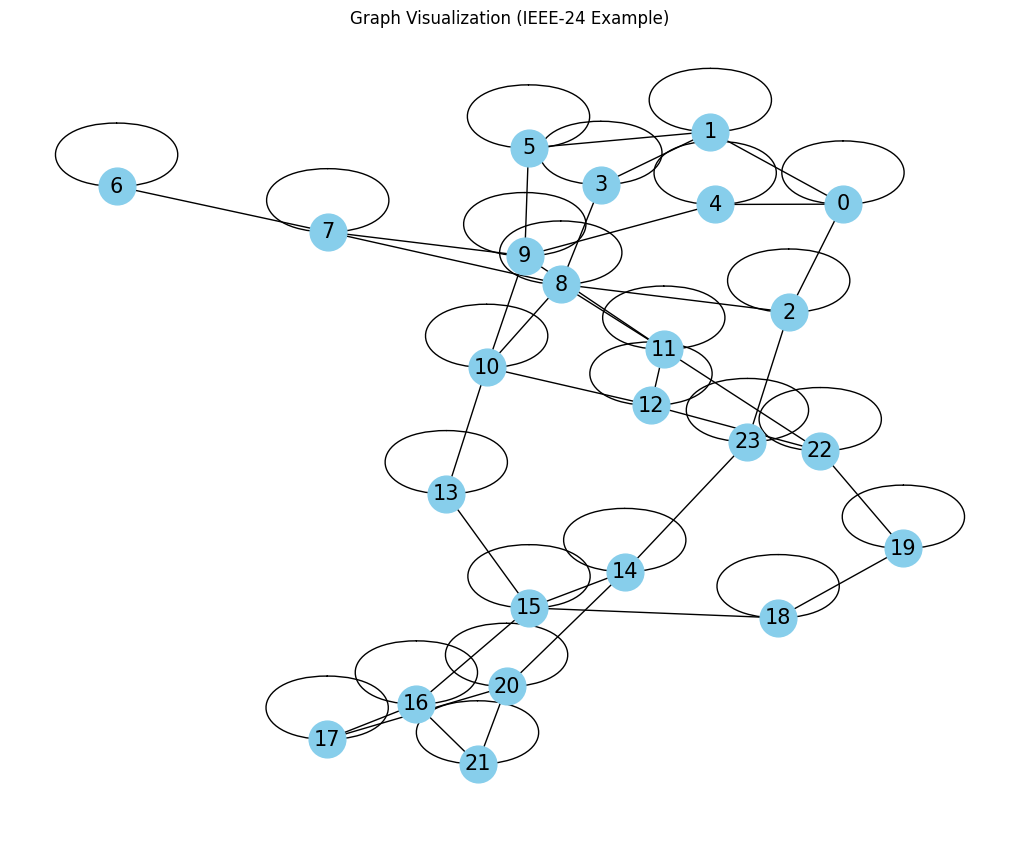

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Assuming 'data' object is available from the previous loading step (cell IM9tLdmltpJp)
if 'data' in locals():
    # Convert the PyG Data object to a NetworkX graph
    # PyG stores edge_index as [2, num_edges], NetworkX expects a list of edges (pairs of nodes)
    # We also need to handle potential self-loops and duplicate edges if they exist in edge_index
    G = nx.Graph() # Use nx.DiGraph() for directed graph

    # Add nodes
    num_nodes = data.num_nodes if hasattr(data, 'num_nodes') and data.num_nodes is not None else data.x.shape[0] if hasattr(data, 'x') and data.x is not None else edge_index.max().item() + 1 if hasattr(data, 'edge_index') and data.edge_index is not None else 0
    G.add_nodes_from(range(num_nodes))

    # Add edges from edge_index
    if hasattr(data, 'edge_index'):
        edge_list = data.edge_index.t().tolist() # Transpose and convert to list of lists
        G.add_edges_from(edge_list)

    print(f"Created NetworkX graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Draw the graph
    plt.figure(figsize=(10, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)
    plt.title("Graph Visualization (IEEE-24 Example)")
    plt.show()
else:
    print("Error: 'data' object not found. Please run the data loading cell first.")

In [17]:
# Assuming 'data' object is available from the previous loading step (cell IM9tLdmltpJp)
if 'data' in locals():
    print("Data object attributes:")
    print(f"data.x (Node features): shape={data.x.shape}, dtype={data.x.dtype}")
    # Print a few values if the tensor is not too large
    if data.x.numel() > 0:
        print(f"First 5 values of data.x:\n{data.x[:5]}")

    print(f"\ndata.edge_index (Graph connectivity): shape={data.edge_index.shape}, dtype={data.edge_index.dtype}")
    if data.edge_index.numel() > 0:
        print(f"First 5 edge indices:\n{data.edge_index[:, :5]}")


    if data.edge_attr is not None:
        print(f"\ndata.edge_attr (Edge features): shape={data.edge_attr.shape}, dtype={data.edge_attr.dtype}")
        if data.edge_attr.numel() > 0:
            print(f"First 5 edge attributes:\n{data.edge_attr[:5]}")

    if data.y is not None:
        print(f"\ndata.y (Ground truth): shape={data.y.shape}, dtype={data.y.dtype}")
        if data.y.numel() > 0:
            print(f"First 5 ground truth values:\n{data.y[:5]}")

else:
    print("Error: 'data' object not found. Please run the data loading cell first.")

Data object attributes:
data.x (Node features): shape=torch.Size([24, 4]), dtype=torch.float32
First 5 values of data.x:
tensor([[-58.0081, -22.0000,   0.0000,   2.0000],
        [-52.0999, -20.0000,   0.0000,   2.0000],
        [-96.6802, -37.0000,   0.0000,   1.0000],
        [-39.7463, -15.0000,   0.0000,   1.0000],
        [-38.1350, -14.0000,   0.0000,   1.0000]])

data.edge_index (Graph connectivity): shape=torch.Size([2, 92]), dtype=torch.int64
First 5 edge indices:
tensor([[0, 1, 2, 4, 0],
        [0, 0, 0, 0, 1]])

data.edge_attr (Edge features): shape=torch.Size([92, 2]), dtype=torch.float32
First 5 edge attributes:
tensor([[ 17.0119, -84.7739],
        [-13.0020,  69.5104],
        [ -1.1474,   4.4382],
        [ -2.8626,  11.0958],
        [-13.0020,  69.5104]])

data.y (Ground truth): shape=torch.Size([24, 4]), dtype=torch.float32
First 5 ground truth values:
tensor([[62.4000, -3.5839,  1.0268, -7.1528],
        [62.4000, -8.8057,  1.0264, -7.2336],
        [ 0.0000,  0.00

In [29]:
import random
import torch

# Assuming 'dataset' is the list of PyG Data objects created in the previous step

if 'dataset' in locals() and len(dataset) > 0:
    # Define the splitting ratios
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1

    # Ensure the ratios sum to 1 (or slightly less due to rounding)
    if not (train_ratio + val_ratio + test_ratio) <= 1.01:
         print("Warning: Splitting ratios do not sum up to 1.0")

    # Shuffle the dataset
    random.shuffle(dataset)

    # Calculate the number of samples for each set
    num_samples = len(dataset)
    num_train = int(num_samples * train_ratio)
    num_val = int(num_samples * val_ratio)
    num_test = num_samples - num_train - num_val # Assign remaining to test

    # Split the dataset
    train_dataset = dataset[:num_train]
    val_dataset = dataset[num_train:num_train + num_val]
    test_dataset = dataset[num_train + num_val:]

    print(f"Dataset split into:")
    print(f"  Training set: {len(train_dataset)} samples")
    print(f"  Validation set: {len(val_dataset)} samples")
    print(f"  Testing set: {len(test_dataset)} samples")

    # Optional: Display a sample from the training set
    if len(train_dataset) > 0:
        print("\nFirst Data object in the training set:")
        print(train_dataset[0])
        print("edge attribute dimentions: ",dataset[0].edge_attr.shape[1])

else:
    print("Error: 'dataset' not found or is empty. Please run the data loading cell first.")

Dataset split into:
  Training set: 27867 samples
  Validation set: 3483 samples
  Testing set: 3484 samples

First Data object in the training set:
Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4])
edge attribute dimentions:  2


In [19]:
!pip install torch_geometric

First, let's define a simple **Graph Convolutional Network (GCN)** model.

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv 
GCNConv=NNConv
class GCN(torch.nn.Module):
    def __init__(self, in_channels,edge_attr_dim, hidden_channels, out_channels):
        super().__init__()

        #define the edge network that maps edge_attr to weights
        self.edge_network1=nn.Sequential(
            nn.Linear(edge_attr_dim, hidden_channels*in_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels*in_channels, hidden_channels*in_channels)
        )

        self.conv1 = GCNConv(in_channels, hidden_channels, self.edge_network1, aggr='mean')

        self.edge_network2=nn.Sequential(
            nn.Linear(edge_attr_dim, hidden_channels*hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels*hidden_channels, hidden_channels*out_channels)
        )
        self.conv2 = GCNConv(hidden_channels, out_channels, self.edge_network2, aggr='mean')

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)

        return x # Return raw output for potential loss calculation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv 

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        #define the edge network that maps edge_attr to weights
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)

        return x # Return raw output for potential loss calculation

Next, let's define a simple **Graph Attention Network (GAT)** model.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1) # Output layer usually has heads=1

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x # Return raw output for potential loss calculation

### Instantiate Models and Set up Training

In [38]:
import torch
import torch.optim as optim

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define model parameters
# You might need to adjust these based on your data and experimentation
# in_channels = number of input features per node (from data.x)
# out_channels = number of output tasks per node (from data.y)
# hidden_channels = number of features in the hidden layers (can be adjusted)

# Assuming data.x has shape [num_nodes, in_channels] and data.y has shape [num_nodes, out_channels]
# We can get these from the first Data object in the training set
if len(train_dataset) > 0:
    sample_data = train_dataset[0]
    in_channels = sample_data.x.shape[1]
    out_channels = sample_data.y.shape[1] if sample_data.y is not None else 1 # Assuming at least 1 output if y is None
    hidden_channels = 64 # Example value, can be tuned
    edge_attr_dim= sample_data.edge_attr.shape[1]
    print(f"Model parameters: in_channels={in_channels}, hidden_channels={hidden_channels}, out_channels={out_channels}")

    # Instantiate GCN Model
    gcn_model = GCN(in_channels, hidden_channels, out_channels).to(device)
    #gcn_model = GCN(in_channels,edge_attr_dim, hidden_channels, out_channels).to(device)
    print("\nGCN Model:")
    print(gcn_model)

    # Instantiate GAT Model
    # You can adjust the number of heads in GATConv if needed
    gat_model = GAT(in_channels, hidden_channels, out_channels, heads=4).to(device) # Example: 4 attention heads
    print("\nGAT Model:")
    print(gat_model)

    # Define Loss Function (e.g., Mean Squared Error for regression tasks)
    criterion = nn.MSELoss()
    print("\nLoss Function: MSELoss")

    # Define Optimizers
    gcn_optimizer = optim.Adam(gcn_model.parameters(), lr=0.01) # Example learning rate
    gat_optimizer = optim.Adam(gat_model.parameters(), lr=0.01)
    print("Optimizers: Adam for both models")

    # Note: Data needs to be moved to the device during training loops.
    # This is typically done inside the training and evaluation functions.

else:
    print("Error: Training dataset is empty. Cannot instantiate models.")

Using device: cpu
Model parameters: in_channels=4, hidden_channels=64, out_channels=4

GCN Model:
GCN(
  (edge_network1): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv1): NNConv(4, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  ))
  (edge_network2): Sequential(
    (0): Linear(in_features=2, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=256, bias=True)
  )
  (conv2): NNConv(64, 4, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=256, bias=True)
  ))
)

GAT Model:
GAT(
  (conv1): GATConv(4, 64, heads=4)
  (conv2): GATConv(256, 4, heads=1)
)

Loss Function: MSELoss
Optimizers: Adam for both models


### Implement Training Function

In [39]:
import torch

def train(model, optimizer, criterion, dataset, device):
    model.train() # Set the model to training mode
    total_loss = 0
    for data in dataset:
        data = data.to(device) # Move data to the specified device
        optimizer.zero_grad() # Clear gradients
        out = model(data) # Perform a forward pass
        loss = criterion(out, data.y) # Calculate the loss
        loss.backward() # Perform backpropagation
        optimizer.step() # Update model parameters
        total_loss += loss.item() # Accumulate loss for the current sample

    # Return average loss for the epoch
    return total_loss / len(dataset)

### Implement Evaluation Function

In [40]:
import torch

def evaluate(model, criterion, dataset, device):
    model.eval() # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad(): # Disable gradient computation
        for data in dataset:
            data = data.to(device) # Move data to the specified device
            out = model(data) # Perform a forward pass
            loss = criterion(out, data.y) # Calculate the loss
            total_loss += loss.item() # Accumulate loss for the current sample

    # Return average loss for the dataset
    return total_loss / len(dataset)

### Train and Evaluate Models

In [41]:
import time

# Assuming models, optimizers, criterion, train_dataset, val_dataset, and device are defined from previous steps

# Define number of epochs
num_epochs = 10 # You can adjust this

# Lists to store loss values for plotting or analysis
gcn_train_losses = []
gcn_val_losses = []
gat_train_losses = []
gat_val_losses = []

print("Starting training for GCN model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(gcn_model, gcn_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(gcn_model, criterion, val_dataset, device)

    gcn_train_losses.append(train_loss)
    gcn_val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GCN Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')

# print("\nStarting training for GAT model...")
# for epoch in range(1, num_epochs + 1):
#     start_time = time.time()
#     train_loss = train(gat_model, gat_optimizer, criterion, train_dataset, device)
#     val_loss = evaluate(gat_model, criterion, val_dataset, device)

#     gat_train_losses.append(train_loss)
#     gat_val_losses.append(val_loss)

#     end_time = time.time()
#     epoch_time = end_time - start_time

#     print(f'GAT Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')

# print("\nTraining complete for GAT model.")

# Optional: You can now use test_dataset to evaluate the final performance
# print("\nEvaluating GCN on test set...")
# test_loss_gcn = evaluate(gcn_model, criterion, test_dataset, device)
# print(f'GCN Test Loss: {test_loss_gcn:.4f}')

# print("\nEvaluating GAT on test set...")
# test_loss_gat = evaluate(gat_model, criterion, test_dataset, device)
# print(f'GAT Test Loss: {test_loss_gat:.4f}')

Starting training for GCN model...
GCN Epoch: 001, Train Loss: 2086631257.7603, Val Loss: 4065.8420, Time: 649.49s
GCN Epoch: 002, Train Loss: 4092.8291, Val Loss: 4065.8918, Time: 646.22s
GCN Epoch: 003, Train Loss: 4092.8305, Val Loss: 4065.8918, Time: 644.28s


In [ ]:
import copy
import numpy as np

class EarlyStopping:
    def __init__(self, patience=10, delta=1e-4):
        """
        Args:
            patience (int): how many epochs to wait before stopping if no improvement
            delta (float): minimum change to count as improvement
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.best_model_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
            return False  # not early stopping
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # trigger early stop
            return False


StatementMeta(, , -1, Waiting, , Waiting)

In [ ]:
early_stopper = EarlyStopping(patience=10)

print("\nStarting training for GAT model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(gat_model, gat_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(gat_model, criterion, val_dataset, device)

    gat_train_losses.append(train_loss)
    gat_val_losses.append(val_loss)
    
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'GAT Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')

    if early_stopper.step(val_loss, gat_model):
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best model weights
gat_model.load_state_dict(early_stopper.best_model_state)
print("Best model restored.")


StatementMeta(, , -1, Waiting, , Waiting)

In [ ]:
# Save the restored best model to disk
torch.save(gat_model.state_dict(), "gat_model_best.pth")
print("Model saved as 'gat_model_best.pth'")


StatementMeta(, , -1, Waiting, , Waiting)

In [ ]:
# Recreate the model architecture
gat_model = GAT(in_channels=4, hidden_channels=64, out_channels=4).to(device)

# Load the saved weights
gat_model.load_state_dict(torch.load("gat_model_best.pth"))
gat_model.eval()  # Set to evaluation mode


StatementMeta(, , -1, Waiting, , Waiting)

Define the GraphSAGE, TGN/DySAT, and GIN model architectures using PyTorch Geometric layers.

Reasoning: Define the GraphSAGE, StandardGNN (as the graph is static), and GIN model architectures as requested, incorporating the necessary PyTorch Geometric layers.

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GINConv # Import SAGEConv and GINConv

# Define GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x # Return raw output for potential loss calculation

# Define StandardGNN Model (since the graph is static)
class StandardGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Using GCNConv for simplicity as a standard static GNN layer
        from torch_geometric.nn import GCNConv # Import GCNConv if not already imported
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x # Return raw output for potential loss calculation


# Define GIN Model
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # GINConv requires a neural network for aggregation
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv1 = GINConv(nn1)

        nn2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, out_channels)
        )
        self.conv2 = GINConv(nn2)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x # Return raw output for potential loss calculation

print("GraphSAGE, StandardGNN, and GIN models defined.")

GraphSAGE, StandardGNN, and GIN models defined.


Reasoning: The models have been defined. The next step is to instantiate these new models and set up their optimizers and criterion, similar to what was done for GCN and GAT.

In [27]:
import torch.optim as optim

# Assuming in_channels, hidden_channels, out_channels and device are defined from previous steps

# Instantiate GraphSAGE Model
graphsage_model = GraphSAGE(in_channels, hidden_channels, out_channels).to(device)
print("\nGraphSAGE Model:")
print(graphsage_model)

# Instantiate StandardGNN Model
standardgnn_model = StandardGNN(in_channels, hidden_channels, out_channels).to(device)
print("\nStandardGNN Model:")
print(standardgnn_model)

# Instantiate GIN Model
gin_model = GIN(in_channels, hidden_channels, out_channels).to(device)
print("\nGIN Model:")
print(gin_model)

# Define Optimizers for the new models
graphsage_optimizer = optim.Adam(graphsage_model.parameters(), lr=0.01) # Example learning rate
standardgnn_optimizer = optim.Adam(standardgnn_model.parameters(), lr=0.01)
gin_optimizer = optim.Adam(gin_model.parameters(), lr=0.01)
print("Optimizers: Adam for GraphSAGE, StandardGNN, and GIN models")

# Criterion (MSELoss) is already defined
print("Loss Function: MSELoss (already defined)")


GraphSAGE Model:
GraphSAGE(
  (conv1): SAGEConv(4, 64, aggr=mean)
  (conv2): SAGEConv(64, 4, aggr=mean)
)

StandardGNN Model:
StandardGNN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 4)
)

GIN Model:
GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  ))
)
Optimizers: Adam for GraphSAGE, StandardGNN, and GIN models
Loss Function: MSELoss (already defined)


Reasoning: The models are defined and instantiated. The next step is to train and evaluate the new models (GraphSAGE, StandardGNN, GIN) using the previously defined train and evaluate functions.

In [32]:
import time

# Assuming models, optimizers, criterion, train_dataset, val_dataset, and device are defined

# Lists to store loss values for plotting or analysis
graphsage_train_losses = []
graphsage_val_losses = []
standardgnn_train_losses = []
standardgnn_val_losses = []
gin_train_losses = []
gin_val_losses = []
gcn_train_losses = []
gcn_val_losses = []
gat_train_losses = []
gat_val_losses = []




num_epochs = 100 # Use the same number of epochs

print("\nStarting training for GraphSAGE model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(graphsage_model, graphsage_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(graphsage_model, criterion, val_dataset, device)

    graphsage_train_losses.append(train_loss)
    graphsage_val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GraphSAGE Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')

print("\nStarting training for StandardGNN model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(standardgnn_model, standardgnn_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(standardgnn_model, criterion, val_dataset, device)

    standardgnn_train_losses.append(train_loss)
    standardgnn_val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'StandardGNN Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')


print("\nStarting training for GIN model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(gin_model, gin_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(gin_model, criterion, val_dataset, device)

    gin_train_losses.append(train_loss)
    gin_val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GIN Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')


print("\nTraining complete for GraphSAGE, StandardGNN, and GIN models.")


print("\nStarting training for GAT model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(gat_model, gat_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(gat_model, criterion, val_dataset, device)

    gat_train_losses.append(train_loss)
    gat_val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GAT Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')


print("Starting training for GCN model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(gcn_model, gcn_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(gcn_model, criterion, val_dataset, device)

    gcn_train_losses.append(train_loss)
    gcn_val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GCN Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')


# Evaluate on test set
print("\nEvaluating GraphSAGE on test set...")
test_loss_graphsage = evaluate(graphsage_model, criterion, test_dataset, device)
print(f'GraphSAGE Test Loss: {test_loss_graphsage:.4f}')

print("\nEvaluating StandardGNN on test set...")
test_loss_standardgnn = evaluate(standardgnn_model, criterion, test_dataset, device)
print(f'StandardGNN Test Loss: {test_loss_standardgnn:.4f}')

print("\nEvaluating GIN on test set...")
test_loss_gin = evaluate(gin_model, criterion, test_dataset, device)
print(f'GIN Test Loss: {test_loss_gin:.4f}')

print("\nEvaluating GAT on test set...")
test_loss_gat = evaluate(gat_model, criterion, test_dataset, device)
print(f'GAT Test Loss: {test_loss_gat:.4f}')

print("\nEvaluating GCN on test set...")
test_loss_gcn = evaluate(gcn_model, criterion, test_dataset, device)
print(f'GCN Test Loss: {test_loss_gcn:.4f}')

StatementMeta(f569027e-acba-4226-832b-c0f313bf77b0, 3, 37, Submitted, Running, Running)


Starting training for GraphSAGE model...
GraphSAGE Epoch: 001, Train Loss: 340.3857, Val Loss: 166.3903, Time: 56.57s
GraphSAGE Epoch: 002, Train Loss: 328.6691, Val Loss: 189.3202, Time: 55.48s
GraphSAGE Epoch: 003, Train Loss: 325.1850, Val Loss: 174.5110, Time: 55.60s
GraphSAGE Epoch: 004, Train Loss: 321.0080, Val Loss: 230.7214, Time: 56.50s
GraphSAGE Epoch: 005, Train Loss: 319.9088, Val Loss: 157.1793, Time: 55.57s
GraphSAGE Epoch: 006, Train Loss: 318.2260, Val Loss: 166.2852, Time: 56.88s
GraphSAGE Epoch: 007, Train Loss: 316.3652, Val Loss: 171.8149, Time: 56.16s
GraphSAGE Epoch: 008, Train Loss: 315.4953, Val Loss: 179.4927, Time: 56.68s
GraphSAGE Epoch: 009, Train Loss: 315.9783, Val Loss: 154.7600, Time: 56.35s
GraphSAGE Epoch: 010, Train Loss: 313.9324, Val Loss: 137.8782, Time: 56.77s
GraphSAGE Epoch: 011, Train Loss: 313.6815, Val Loss: 144.8547, Time: 57.02s
GraphSAGE Epoch: 012, Train Loss: 313.9053, Val Loss: 161.9479, Time: 55.87s
GraphSAGE Epoch: 013, Train Loss: 

In [29]:
# Evaluate on test set
print("\nEvaluating GraphSAGE on test set...")
test_loss_graphsage = evaluate(graphsage_model, criterion, test_dataset, device)
print(f'GraphSAGE Test Loss: {test_loss_graphsage:.4f}')

print("\nEvaluating StandardGNN on test set...")
test_loss_standardgnn = evaluate(standardgnn_model, criterion, test_dataset, device)
print(f'StandardGNN Test Loss: {test_loss_standardgnn:.4f}')

print("\nEvaluating GIN on test set...")
test_loss_gin = evaluate(gin_model, criterion, test_dataset, device)
print(f'GIN Test Loss: {test_loss_gin:.4f}')

print("\nEvaluating GAT on test set...")
test_loss_gat = evaluate(gat_model, criterion, test_dataset, device)
print(f'GAT Test Loss: {test_loss_gat:.4f}')

print("\nEvaluating GCN on test set...")
test_loss_gcn = evaluate(gcn_model, criterion, test_dataset, device)
print(f'GCN Test Loss: {test_loss_gcn:.4f}')

print("\n--- Model Comparison ---")
print(f"GCN Test Loss: {test_loss_gcn:.4f}")
print(f"GAT Test Loss: {test_loss_gat:.4f}")
print(f"GraphSAGE Test Loss: {test_loss_graphsage:.4f}")
print(f"StandardGNN Test Loss: {test_loss_standardgnn:.4f}")
print(f"GIN Test Loss: {test_loss_gin:.4f}")

# You can further analyze these results, e.g., identify the model with the lowest test loss.


Evaluating GraphSAGE on test set...
GraphSAGE Test Loss: 2472.5427

Evaluating StandardGNN on test set...
StandardGNN Test Loss: 1324.8087

Evaluating GIN on test set...
GIN Test Loss: 1880.8778

Evaluating GAT on test set...
GAT Test Loss: 1458.3958

Evaluating GCN on test set...
GCN Test Loss: 1464.2920

--- Model Comparison ---
GCN Test Loss: 1464.2920
GAT Test Loss: 1458.3958
GraphSAGE Test Loss: 2472.5427
StandardGNN Test Loss: 1324.8087
GIN Test Loss: 1880.8778


In [30]:
# Evaluate on test set
print("\nEvaluating GraphSAGE on test set...")
test_loss_graphsage = evaluate(graphsage_model, criterion, test_dataset, device)
print(f'GraphSAGE Test Loss: {test_loss_graphsage:.4f}')

print("\nEvaluating StandardGNN on test set...")
test_loss_standardgnn = evaluate(standardgnn_model, criterion, test_dataset, device)
print(f'StandardGNN Test Loss: {test_loss_standardgnn:.4f}')

print("\nEvaluating GIN on test set...")
test_loss_gin = evaluate(gin_model, criterion, test_dataset, device)
print(f'GIN Test Loss: {test_loss_gin:.4f}')

print("\nEvaluating GAT on test set...")
test_loss_gat = evaluate(gat_model, criterion, test_dataset, device)
print(f'GAT Test Loss: {test_loss_gat:.4f}')

print("\nEvaluating GCN on test set...")
test_loss_gcn = evaluate(gcn_model, criterion, test_dataset, device)
print(f'GCN Test Loss: {test_loss_gcn:.4f}')

print("\n--- Model Comparison ---")
print(f"GCN Test Loss: {test_loss_gcn:.4f}")
print(f"GAT Test Loss: {test_loss_gat:.4f}")
print(f"GraphSAGE Test Loss: {test_loss_graphsage:.4f}")
print(f"StandardGNN Test Loss: {test_loss_standardgnn:.4f}")
print(f"GIN Test Loss: {test_loss_gin:.4f}")

# You can further analyze these results, e.g., identify the model with the lowest test loss.


Evaluating GraphSAGE on test set...
GraphSAGE Test Loss: 2472.5427

Evaluating StandardGNN on test set...
StandardGNN Test Loss: 1324.8087

Evaluating GIN on test set...
GIN Test Loss: 1880.8778

Evaluating GAT on test set...
GAT Test Loss: 1458.3958

Evaluating GCN on test set...
GCN Test Loss: 1464.2920

--- Model Comparison ---
GCN Test Loss: 1464.2920
GAT Test Loss: 1458.3958
GraphSAGE Test Loss: 2472.5427
StandardGNN Test Loss: 1324.8087
GIN Test Loss: 1880.8778


In [26]:
import matplotlib.pyplot as plt
num_epochs = 100
# Assuming the loss lists (gcn_train_losses, gcn_val_losses, etc.) are populated from the training loop

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# # Plot GCN losses
# plt.plot(epochs, gcn_train_losses, label='GCN Train Loss')
# plt.plot(epochs, gcn_val_losses, label='GCN Validation Loss')

# # Plot GAT losses
# plt.plot(epochs, gat_train_losses, label='GAT Train Loss')
# plt.plot(epochs, gat_val_losses, label='GAT Validation Loss')

# Plot GraphSAGE losses
plt.plot(epochs, graphsage_train_losses, label='GraphSAGE Train Loss')
plt.plot(epochs, graphsage_val_losses, label='GraphSAGE Validation Loss')

# Plot StandardGNN losses
plt.plot(epochs, standardgnn_train_losses, label='StandardGNN Train Loss')
plt.plot(epochs, standardgnn_val_losses, label='StandardGNN Validation Loss')

# Plot GIN losses
plt.plot(epochs, gin_train_losses, label='GIN Train Loss')
plt.plot(epochs, gin_val_losses, label='GIN Validation Loss')


plt.title('Training and Validation Loss Curves for GNN Models')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

print("\nComparison of Test Losses:")
print(f"GCN Test Loss: {test_loss_gcn:.4f}")
print(f"GAT Test Loss: {test_loss_gat:.4f}")
print(f"GraphSAGE Test Loss: {test_loss_graphsage:.4f}")
print(f"StandardGNN Test Loss: {test_loss_standardgnn:.4f}")
print(f"GIN Test Loss: {test_loss_gin:.4f}")

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

# Import tensorboard
Subtask:
Import the necessary libraries from torch.utils.tensorboard.

In [28]:
from torch.utils.tensorboard import SummaryWriter

2025-09-25 07:50:16.527260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758786617.470845    3118 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758786617.731537    3118 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758786620.235707    3118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758786620.235769    3118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758786620.235773    3118 computation_placer.cc:177] computation placer alr

In [29]:
# Instantiate a SummaryWriter
# Specify a log directory, e.g., 'runs/model_training'
writer = SummaryWriter('runs/model_training')
print(f"SummaryWriter instantiated, logging to '{writer.log_dir}'")

SummaryWriter instantiated, logging to 'runs/model_training'


In [30]:
import time

# Assuming models, optimizers, criterion, train_dataset, val_dataset, and device are defined
# Assuming SummaryWriter object 'writer' is instantiated

# Define number of epochs
num_epochs = 10

# Lists to store loss values for plotting or analysis (optional, for matplotlib plot later)
gcn_train_losses = []
gcn_val_losses = []
gat_train_losses = []
gat_val_losses = []
graphsage_train_losses = []
graphsage_val_losses = []
standardgnn_train_losses = []
standardgnn_val_losses = []
gin_train_losses = []
gin_val_losses = []


print("\nStarting training for GraphSAGE model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(graphsage_model, graphsage_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(graphsage_model, criterion, val_dataset, device)

    graphsage_train_losses.append(train_loss)
    graphsage_val_losses.append(val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/GraphSAGE/Train', train_loss, epoch)
    writer.add_scalar('Loss/GraphSAGE/Validation', val_loss, epoch)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GraphSAGE Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')

print("\nStarting training for StandardGNN model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(standardgnn_model, standardgnn_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(standardgnn_model, criterion, val_dataset, device)

    standardgnn_train_losses.append(train_loss)
    standardgnn_val_losses.append(val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/StandardGNN/Train', train_loss, epoch)
    writer.add_scalar('Loss/StandardGNN/Validation', val_loss, epoch)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'StandardGNN Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')


print("\nStarting training for GIN model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(gin_model, gin_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(gin_model, criterion, val_dataset, device)

    gin_train_losses.append(train_loss)
    gin_val_losses.append(val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/GIN/Train', train_loss, epoch)
    writer.add_scalar('Loss/GIN/Validation', val_loss, epoch)


    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GIN Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')


print("\nStarting training for GAT model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(gat_model, gat_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(gat_model, criterion, val_dataset, device)

    gat_train_losses.append(train_loss)
    gat_val_losses.append(val_loss)

     # Log losses to TensorBoard
    writer.add_scalar('Loss/GAT/Train', train_loss, epoch)
    writer.add_scalar('Loss/GAT/Validation', val_loss, epoch)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GAT Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')


print("Starting training for GCN model...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss = train(gcn_model, gcn_optimizer, criterion, train_dataset, device)
    val_loss = evaluate(gcn_model, criterion, val_dataset, device)

    gcn_train_losses.append(train_loss)
    gcn_val_losses.append(val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/GCN/Train', train_loss, epoch)
    writer.add_scalar('Loss/GCN/Validation', val_loss, epoch)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'GCN Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')


print("\nTraining complete for all models.")

# Close the writer to ensure all logged data is saved
writer.close()
print("SummaryWriter closed.")

# Optional: You can now use test_dataset to evaluate the final performance
print("\nEvaluating GraphSAGE on test set...")
test_loss_graphsage = evaluate(graphsage_model, criterion, test_dataset, device)
print(f'GraphSAGE Test Loss: {test_loss_graphsage:.4f}')

print("\nEvaluating StandardGNN on test set...")
test_loss_standardgnn = evaluate(standardgnn_model, criterion, test_dataset, device)
print(f'StandardGNN Test Loss: {test_loss_standardgnn:.4f}')

print("\nEvaluating GIN on test set...")
test_loss_gin = evaluate(gin_model, criterion, test_dataset, device)
print(f'GIN Test Loss: {test_loss_gin:.4f}')

print("\nEvaluating GAT on test set...")
test_loss_gat = evaluate(gat_model, criterion, test_dataset, device)
print(f'GAT Test Loss: {test_loss_gat:.4f}')

print("\nEvaluating GCN on test set...")
test_loss_gcn = evaluate(gcn_model, criterion, test_dataset, device)
print(f'GCN Test Loss: {test_loss_gcn:.4f}')


Starting training for GraphSAGE model...
GraphSAGE Epoch: 001, Train Loss: 1091.9657, Val Loss: 623.0409, Time: 52.54s
GraphSAGE Epoch: 002, Train Loss: 1139.8897, Val Loss: 664.7434, Time: 53.21s
GraphSAGE Epoch: 003, Train Loss: 1236.3223, Val Loss: 742.4667, Time: 52.93s
GraphSAGE Epoch: 004, Train Loss: 1286.9919, Val Loss: 784.8714, Time: 52.47s
GraphSAGE Epoch: 005, Train Loss: 1371.7626, Val Loss: 781.4873, Time: 51.58s
GraphSAGE Epoch: 006, Train Loss: 1380.9330, Val Loss: 787.4565, Time: 51.21s
GraphSAGE Epoch: 007, Train Loss: 1475.9258, Val Loss: 942.0264, Time: 51.08s
GraphSAGE Epoch: 008, Train Loss: 1557.6827, Val Loss: 1085.0805, Time: 50.74s
GraphSAGE Epoch: 009, Train Loss: 1547.5243, Val Loss: 914.5276, Time: 50.95s
GraphSAGE Epoch: 010, Train Loss: 1388.5107, Val Loss: 742.8362, Time: 49.55s

Starting training for StandardGNN model...
StandardGNN Epoch: 001, Train Loss: 2374.8261, Val Loss: 1996.4243, Time: 58.13s
StandardGNN Epoch: 002, Train Loss: 2384.7850, Val L

Launch TensorBoard
Now, let's launch the TensorBoard interface to visualize the logged training and validation losses.

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Launch TensorBoard, pointing it to the log directory
%tensorboard --logdir runs/model_training

In [2]:
torch.save(graphsage_model.state_dict(), "graphsage_model.pth")
torch.save(standardgnn_model.state_dict(), "standardgnn_model.pth")
torch.save(gin_model.state_dict(), "gin_model.pth")
torch.save(gat_model.state_dict(), "gat_model.pth")
torch.save(gcn_model.state_dict(), "gcn_model.pth")

NameError: name 'torch' is not defined

In [33]:
from IPython.display import FileLink

# Create links for each model
FileLink("graphsage_model.pth")
FileLink("standardgnn_model.pth")
FileLink("gin_model.pth")
FileLink("gat_model.pth")
FileLink("gcn_model.pth")


/mnt/batch/tasks/shared/LS_root/mounts/clusters/highpowercpu/code/Users/2606536312/Powerflow/gcn_model.pth

After Evaluation we can see GraphSAGE is the best trained model so far
# So, next step is for hyperparameter-tuning.

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [optuna]2m4/5 [optuna]]


In [2]:
!pip install dataloader

  Preparing metadata (setup.py) ... - done
  DEPRECATION: Building 'dataloader' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'dataloader'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for dataloader: filename=dataloader-2.0-py3-none-any.whl size=10114 sha256=970701ef77da13b01c19a2c0150644629efc58eecbeeea933415586979aaf560
  Stored in directory: /home/azureuser/.cache/pip/wheels/60/56/53/2b1c14a2abb6f40f1d59f97461a59e61f326433fac416794de
Successfully built dataloader


In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [22]:
# Optuna tuning for GraphSAGE (multi-output node regression, MSE objective)
# Assumes: `dataset` is a Python list of torch_geometric.data.Data objects (as you showed)
# Each Data has: x, edge_index, edge_attr (optional), y (shape [num_nodes, 4])
# Requirements: pip install optuna torch-geometric

import os
import time
import math
import random
import optuna
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split

# -----------------------
# Device
# -----------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# -----------------------
# Sanity checks and dims
# -----------------------
if not isinstance(dataset, (list, tuple)) or len(dataset) == 0:
    raise ValueError("`dataset` must be a non-empty list of torch_geometric.data.Data objects.")

# infer input / output dims from first graph
sample = dataset[0]
in_channels = sample.x.shape[1]
# assume y is shape [num_nodes, out_dim]
out_dim = sample.y.shape[1] if sample.y.ndim == 2 else 1
print(f"in_channels={in_channels}, out_dim={out_dim}, num_graphs={len(dataset)}")

# -----------------------
# Model builder
# -----------------------
class GraphSAGERegression(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.2, use_batchnorm=False):
        super().__init__()
        self.num_layers = max(1, num_layers)
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList() if use_batchnorm else None

        if self.num_layers == 1:
            self.convs.append(SAGEConv(in_channels, out_channels))
        else:
            # first
            self.convs.append(SAGEConv(in_channels, hidden_channels))
            if use_batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
            # middle
            for _ in range(self.num_layers - 2):
                self.convs.append(SAGEConv(hidden_channels, hidden_channels))
                if use_batchnorm:
                    self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
            # last -> out_channels
            self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout
        self.use_batchnorm = use_batchnorm

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            # If not last layer -> activation, bn, dropout
            if i != len(self.convs) - 1:
                if self.use_batchnorm:
                    x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x  # shape [total_nodes_in_batch, out_channels]

# -----------------------
# Utilities: subset loader by indices
# -----------------------
def make_loader_from_indices(dataset_list, indices, batch_size=1, shuffle=True):
    subset = [dataset_list[i] for i in indices]
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

# -----------------------
# Prepare graph-level train/val/test indices
# -----------------------
num_graphs = len(dataset)
all_indices = list(range(num_graphs))
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.125, random_state=42)  # 0.125*0.8 = 0.1 val

print(f"Split sizes -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

# -----------------------
# Optuna objective
# -----------------------
def objective(trial):
    # Hyperparameter search space
    hidden = trial.suggest_categorical("hidden", [32, 64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [1, 2, 4])  # graphs per batch
    epochs = trial.suggest_int("epochs", 10, 50, step=10)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [False, True])

    # Build model
    model = GraphSAGERegression(
        in_channels=in_channels,
        hidden_channels=hidden,
        out_channels=out_dim,
        num_layers=num_layers,
        dropout=dropout,
        use_batchnorm=use_batchnorm
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    train_loader = make_loader_from_indices(dataset, train_idx, batch_size=batch_size, shuffle=True)
    val_loader = make_loader_from_indices(dataset, val_idx, batch_size=batch_size, shuffle=False)

    best_val_mse = float('inf')
    trial.set_user_attr("best_epoch", -1)

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for batch in train_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)  # [sum_nodes_in_batch, out_dim]
            # Prepare target: batch.y is concatenated across graphs in batch
            target = batch.y.to(DEVICE).float()  # shape [sum_nodes_in_batch, out_dim]
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(DEVICE)
                out = model(batch.x, batch.edge_index)
                target = batch.y.to(DEVICE).float()
                mse = F.mse_loss(out, target).item()
                val_losses.append(mse)

        mean_val_mse = float(np.mean(val_losses)) if val_losses else float('inf')
        mean_train_loss = float(np.mean(train_losses)) if train_losses else float('nan')

        # Report and pruning
        trial.report(mean_val_mse, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Save best model state for this trial
        if mean_val_mse < best_val_mse:
            best_val_mse = mean_val_mse
            trial.set_user_attr("best_model_state", {k:v.cpu() for k,v in model.state_dict().items()})
            trial.set_user_attr("best_epoch", epoch)

        # Logging per epoch
        print(f"[Trial {trial.number}] Epoch {epoch}/{epochs} | train_loss={mean_train_loss:.6f} | val_mse={mean_val_mse:.6f} | lr={lr:.2e}")

    # Persist best state to file
    best_state = trial.user_attrs.get("best_model_state", None)
    if best_state is not None:
        os.makedirs("optuna_models", exist_ok=True)
        model_path = os.path.join("optuna_models", f"trial_{trial.number}_best.pth")
        # Save CPU tensors to be loadable on any device
        torch.save(best_state, model_path)
        trial.set_user_attr("best_model_path", model_path)

    return best_val_mse

# -----------------------
# Run the study
# -----------------------
study_name = "graphsage_regression_mse"
storage_name = None  # set "sqlite:///optuna_study.db" if you want persistence
sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=3)

study = optuna.create_study(direction="minimize", study_name=study_name, sampler=sampler, pruner=pruner, storage=storage_name, load_if_exists=True)

N_TRIALS = 30  # reduce if using CPU; increase if GPU and time permits
try:
    study.optimize(objective, n_trials=N_TRIALS)
except KeyboardInterrupt:
    print("Optuna run interrupted by user")

# -----------------------
# Results
# -----------------------
print("Study completed.")
print("Number of finished trials:", len(study.trials))
print("Best trial number:", study.best_trial.number)
print("Best trial value (val MSE):", study.best_trial.value)
print("Best trial params:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

best_model_saved = study.best_trial.user_attrs.get("best_model_path", None)
print("Best model (trial) saved at:", best_model_saved)


[I 2025-10-20 07:09:33,814] A new study created in memory with name: graphsage_regression_mse
/tmp/ipykernel_51034/3124457114.py:101: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/tmp/ipykernel_51034/3124457114.py:102: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
[I 2025-10-20 09:40:12,793] Trial 3 finished with value: 2575.737547746345 and parameters: {'hidden': 64, 'num_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.0012399967836846098, 'weight_decay': 3.5856126103453987e-06, 'batch_size': 1, 'epochs': 50, 'use_batchnorm': True}. Best is trial 1 w

[Trial 0] Epoch 1/50 | train_loss=4548.626769 | val_mse=4261.404344 | lr=1.31e-04
[Trial 0] Epoch 2/50 | train_loss=4142.003185 | val_mse=4153.745793 | lr=1.31e-04
[Trial 0] Epoch 3/50 | train_loss=4038.871495 | val_mse=4052.860512 | lr=1.31e-04
[Trial 0] Epoch 4/50 | train_loss=3940.710006 | val_mse=3955.973741 | lr=1.31e-04
[Trial 0] Epoch 5/50 | train_loss=3846.198008 | val_mse=3862.323272 | lr=1.31e-04
[Trial 0] Epoch 6/50 | train_loss=3754.730806 | val_mse=3771.868652 | lr=1.31e-04
[Trial 0] Epoch 7/50 | train_loss=3666.186436 | val_mse=3684.440534 | lr=1.31e-04
[Trial 0] Epoch 8/50 | train_loss=3580.630459 | val_mse=3599.929581 | lr=1.31e-04
[Trial 0] Epoch 9/50 | train_loss=3498.079189 | val_mse=3518.333193 | lr=1.31e-04
[Trial 0] Epoch 10/50 | train_loss=3418.351787 | val_mse=3439.475448 | lr=1.31e-04
[Trial 0] Epoch 11/50 | train_loss=3341.479119 | val_mse=3363.312861 | lr=1.31e-04
[Trial 0] Epoch 12/50 | train_loss=3267.266183 | val_mse=3289.839715 | lr=1.31e-04
[Trial 0] Epo

In [23]:
import torch
import numpy as np
import torch.nn.functional as F

# 1. Extract best parameters and model path from study
best_trial = study.best_trial
best_params = best_trial.params
best_model_file = best_trial.user_attrs.get("best_model_path", None)

print("Best Hyperparameters:", best_params)
print("Best Model File:", best_model_file)

# 2. Rebuild model using best hyperparameters
model_best = GraphSAGERegression(
    in_channels=in_channels,
    hidden_channels=best_params['hidden'],
    out_channels=out_dim,
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
    use_batchnorm=best_params['use_batchnorm']
).to(DEVICE)

# 3. Load the saved weights
state_dict = torch.load(best_model_file, map_location=DEVICE)
model_best.load_state_dict(state_dict)

# 4. Prepare test loader
test_loader = make_loader_from_indices(dataset, test_idx, batch_size=best_params['batch_size'], shuffle=False)

# 5. Evaluate performance
model_best.eval()
mse_list = []
mae_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(DEVICE)
        pred = model_best(batch.x, batch.edge_index)
        target = batch.y.to(DEVICE).float()
        mse_list.append(F.mse_loss(pred, target).item())
        mae_list.append(F.l1_loss(pred, target).item())

print("📊 Final Test MSE:", np.mean(mse_list))
print("📊 Final Test MAE:", np.mean(mae_list))


Best Hyperparameters: {'hidden': 128, 'num_layers': 4, 'dropout': 0.0, 'lr': 0.0006553565486671011, 'weight_decay': 1.6290309780104368e-06, 'batch_size': 1, 'epochs': 30, 'use_batchnorm': False}
Best Model File: optuna_models/trial_24_best.pth
📊 Final Test MSE: 2.4830898948391282
📊 Final Test MAE: 0.5330623480772996


In [34]:
print(len(dataset))

34834


In [27]:
print(train_idx)

[3505, 18357, 17860, 32860, 2083, 27286, 24490, 6820, 19096, 29112, 19340, 1490, 25093, 15154, 16176, 8421, 22102, 10583, 33412, 33042, 29755, 20341, 13755, 23618, 31190, 10948, 26563, 19750, 3134, 33837, 1300, 3645, 19953, 3307, 31279, 17696, 12101, 26258, 24003, 15055, 29912, 1006, 27104, 6477, 10839, 19345, 11382, 16172, 22588, 23038, 14939, 12595, 25228, 15940, 8985, 28284, 3720, 25395, 30645, 28232, 1364, 26986, 5981, 5370, 12889, 33692, 26966, 2478, 9038, 1700, 20924, 11401, 29414, 27209, 5357, 234, 7459, 34577, 26854, 28566, 13689, 448, 8823, 5229, 6139, 16652, 3767, 21618, 31091, 6588, 11615, 4049, 27552, 4743, 5335, 34561, 365, 21282, 11105, 34747, 21465, 30977, 7706, 31476, 29291, 10936, 34256, 33674, 5251, 9142, 5629, 14253, 3033, 7041, 29842, 31146, 27158, 28816, 4240, 23597, 23355, 25128, 31283, 28947, 16935, 11015, 1420, 26111, 19387, 28976, 2172, 11542, 31030, 2667, 13777, 23952, 13448, 2423, 21642, 31830, 22247, 11736, 32874, 6006, 25688, 9089, 27654, 6717, 30089, 1311,

In [28]:
print(dataset)

[Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4]), Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24,

In [39]:
dataset[train_idx[1]]

Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4])

In [41]:
train_idx[0]

18357

# Retrain on Train + Validation Data

In [26]:
# Combine train and validation indices
final_train_idx = np.concatenate([train_idx, val_idx])
print("Final training dataset size:", len(final_train_idx))
print(final_train_idx.shape)


Final training dataset size: 27867
(27867,)


Set Training Hyperparameters from Best Trial

In [42]:
# Extract best hyperparameters from Optuna trial
best_params = study.best_trial.params

hidden = best_params['hidden']
num_layers = best_params['num_layers']
dropout = best_params['dropout']
lr = best_params['lr']
weight_decay = best_params['weight_decay']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
use_batchnorm = best_params['use_batchnorm']

print("Using Best Hyperparameters:")
print(best_params)


Using Best Hyperparameters:
{'hidden': 128, 'num_layers': 4, 'dropout': 0.0, 'lr': 0.0006553565486671011, 'weight_decay': 1.6290309780104368e-06, 'batch_size': 1, 'epochs': 30, 'use_batchnorm': False}


Final Training Script (with Logging & Saving)

In [44]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 3.1 Build final model
model_final = GraphSAGERegression(
    in_channels=in_channels,
    hidden_channels=hidden,
    out_channels=out_dim,
    num_layers=num_layers,
    dropout=dropout,
    use_batchnorm=use_batchnorm
).to(DEVICE)

optimizer = Adam(model_final.parameters(), lr=lr, weight_decay=weight_decay)

# 3.2 Create loaders
train_loader = make_loader_from_indices(dataset, final_train_idx, batch_size=batch_size, shuffle=True)
test_loader = make_loader_from_indices(dataset, test_idx, batch_size=batch_size, shuffle=False)

# 3.3 Train and track loss
train_losses = []

print("\n🚀 Starting Final Training on Train+Val Combined...")
for epoch in range(epochs):
    model_final.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        pred = model_final(batch.x, batch.edge_index)
        target = batch.y.to(DEVICE).float()
        loss = F.mse_loss(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss (MSE): {avg_loss:.4f}")

# 3.4 Save final model
final_model_path = "final_graphsage_model.pth"
torch.save(model_final.state_dict(), final_model_path)
print(f"\n✅ Final Model Saved at: {final_model_path}")



🚀 Starting Final Training on Train+Val Combined...
Epoch 1/30 | Train Loss (MSE): 55.3393
Epoch 2/30 | Train Loss (MSE): 5.3596
Epoch 3/30 | Train Loss (MSE): 3.5573
Epoch 4/30 | Train Loss (MSE): 2.8430
Epoch 5/30 | Train Loss (MSE): 2.5480
Epoch 6/30 | Train Loss (MSE): 2.2826
Epoch 7/30 | Train Loss (MSE): 2.1162
Epoch 8/30 | Train Loss (MSE): 2.0196
Epoch 9/30 | Train Loss (MSE): 1.9188
Epoch 10/30 | Train Loss (MSE): 1.8357
Epoch 11/30 | Train Loss (MSE): 1.8181
Epoch 12/30 | Train Loss (MSE): 1.7656
Epoch 13/30 | Train Loss (MSE): 1.7315
Epoch 14/30 | Train Loss (MSE): 1.6991
Epoch 15/30 | Train Loss (MSE): 1.6291
Epoch 16/30 | Train Loss (MSE): 1.6023
Epoch 17/30 | Train Loss (MSE): 1.5775
Epoch 18/30 | Train Loss (MSE): 1.5990
Epoch 19/30 | Train Loss (MSE): 1.5394
Epoch 20/30 | Train Loss (MSE): 1.5429
Epoch 21/30 | Train Loss (MSE): 1.4704
Epoch 22/30 | Train Loss (MSE): 1.4919
Epoch 23/30 | Train Loss (MSE): 1.4773
Epoch 24/30 | Train Loss (MSE): 1.4434
Epoch 25/30 | Train 

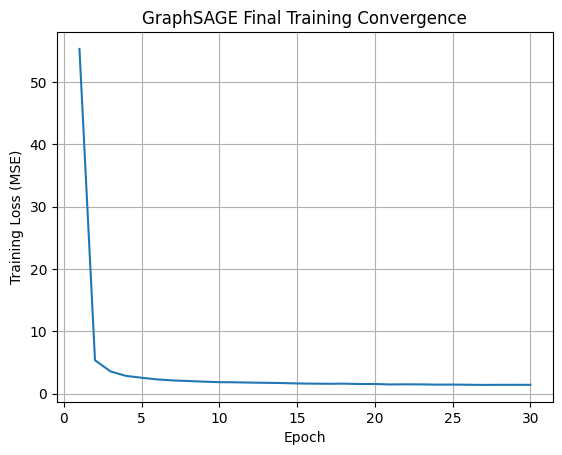

In [45]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("GraphSAGE Final Training Convergence")
plt.grid(True)
plt.show()


In [46]:
model_final.eval()
mse_list = []
mae_list = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(DEVICE)
        pred = model_final(batch.x, batch.edge_index)
        target = batch.y.to(DEVICE).float()
        mse_list.append(F.mse_loss(pred, target).item())
        mae_list.append(F.l1_loss(pred, target).item())

print("\n📊 ***FINAL RESULTS ON TEST SET***")
print("Test MSE:", np.mean(mse_list))
print("Test MAE:", np.mean(mae_list))



📊 ***FINAL RESULTS ON TEST SET***
Test MSE: 0.7319087269266145
Test MAE: 0.18348930307396757


| Explainer                               | Type                            | What It Explains                                                     | Best For                        | Pros                     | Cons                             | Suitable for Our Project?                                             |
| --------------------------------------- | ------------------------------- | -------------------------------------------------------------------- | ------------------------------- | ------------------------ | -------------------------------- | --------------------------------------------------------------------- |
| **GNNExplainer**                        | Model-specific                  | Identifies critical nodes, edges, & features influencing predictions | Node or graph-level predictions | Popular, direct insights | Can be slow for large graphs     | ✅ **Highly Suitable**                                                 |
| **PGExplainer**                         | Model-specific (learning-based) | Learns explanations across multiple graphs                           | When many graphs are available  | Faster, generalizable    | Needs training                   | ✅ Good if dataset is large                                            |
| **GraphSHAP**                           | Model-agnostic SHAP extension   | Feature contributions using sampling                                 | Feature importance analysis     | Works for regression     | Computationally expensive        | ⚠ Optional (Only if feature interpretation is needed)                 |
| **Integrated Gradients**                | Gradient-based                  | How small feature changes affect predictions                         | Continuous features             | Good for regression      | Requires feature gradients       | ✅ If your input features are continuous (like voltage/current values) |
| **Graph Attention Visualization (GAT)** | Built-in explainability         | Visualizes attention weights                                         | If using GAT layers             | Very intuitive           | Only works with attention models | ❌ Not applicable (You used GraphSAGE)                                 |


# First, lets go with GNNExplainer

In [49]:
data

Data(x=[24, 4], edge_index=[2, 92], edge_attr=[92, 2], y=[24, 4])

In [56]:
test_idx

[27881,
 22142,
 3160,
 13211,
 13124,
 22747,
 32656,
 9084,
 15430,
 13287,
 20529,
 4341,
 12611,
 16643,
 17556,
 29232,
 26751,
 7743,
 19234,
 8340,
 29743,
 4283,
 33135,
 8650,
 20772,
 18846,
 14495,
 27204,
 34758,
 23490,
 13315,
 4641,
 16342,
 26046,
 16242,
 10436,
 7567,
 33530,
 3211,
 18937,
 21720,
 31669,
 22509,
 20783,
 25457,
 21152,
 16340,
 23277,
 18234,
 30383,
 25010,
 1000,
 28564,
 14856,
 20928,
 21022,
 24606,
 25720,
 3067,
 12281,
 27969,
 8439,
 23912,
 9971,
 12862,
 34346,
 12346,
 26153,
 3128,
 34491,
 8537,
 21483,
 19009,
 14532,
 23577,
 19884,
 5343,
 3568,
 32294,
 30408,
 14486,
 27393,
 17495,
 19005,
 12908,
 14304,
 22472,
 1423,
 28279,
 31901,
 6176,
 29933,
 29013,
 28104,
 7600,
 13433,
 26235,
 17439,
 30001,
 19286,
 7475,
 30404,
 8135,
 28930,
 31332,
 1291,
 31370,
 10919,
 2974,
 896,
 1448,
 13959,
 26618,
 4756,
 32090,
 5550,
 30388,
 11327,
 16188,
 24011,
 25951,
 23830,
 22849,
 11854,
 4783,
 20763,
 14176,
 8628,
 22741,


In [61]:
graph = dataset[test_idx[0]]

print("\nGraph Info:")
print("x (node features) shape:", graph.x.shape)
print("edge_index shape:", graph.edge_index.shape)
print("y shape:", graph.y.shape)
print("Does this graph represent node-level regression? (y should match node count)")



Graph Info:
x (node features) shape: torch.Size([24, 4])
edge_index shape: torch.Size([2, 92])
y shape: torch.Size([24, 4])
Does this graph represent node-level regression? (y should match node count)


In [66]:
model_final.eval()

with torch.no_grad():
    out = model_final(graph.x, graph.edge_index)  # shape [24, 4]

# Ensure correct shape
predictions = out  # [24, 4]
true_values = graph.y  # [24, 4]

# Compute absolute error for each node across all 4 outputs
node_errors = torch.mean(torch.abs(predictions - true_values), dim=1)  # [24]

# Find highest-error node
max_error_node = torch.argmax(node_errors).item()

critical_pred = predictions[max_error_node].tolist()
critical_true = true_values[max_error_node].tolist()

print(f"🔴 Critical Node Detected: {max_error_node}")
print(f"Predictions: {critical_pred}")
print(f"True Values: {critical_true}")
print(f"Absolute Error per feature: {torch.abs(predictions[max_error_node] - true_values[max_error_node]).tolist()}")
print(f"Mean Error for this node: {node_errors[max_error_node].item():.4f}")

🔴 Critical Node Detected: 22
Predictions: [316.43975830078125, 56.65980911254883, 1.050826907157898, 6.1795454025268555]
True Values: [315.4645690917969, 56.45845413208008, 1.0493569374084473, 6.040412902832031]
Absolute Error per feature: [0.975189208984375, 0.20135498046875, 0.0014699697494506836, 0.13913249969482422]
Mean Error for this node: 0.3293


In [67]:
# Identify neighbors of the critical node
row, col = data.edge_index
neighbors = col[row == max_error_node].tolist() + row[col == max_error_node].tolist()
neighbors = list(set(neighbors))  # unique neighbors

print(f"\n🌐 Neighbors of Node {max_error_node}: {neighbors}")
print(f"Number of Neighbors: {len(neighbors)}")

# You can also check predictions of neighbors (to see if region is problematic)
for n in neighbors:
    pred = out[n].detach().cpu().numpy()
    true = data.y[n].detach().cpu().numpy()
    print(f"\nNeighbor Node {n}: Pred={pred}, True={true}, Error={abs(pred-true).sum():.4f}")



🌐 Neighbors of Node 22: [19, 11, 12, 22]
Number of Neighbors: 4

Neighbor Node 19: Pred=[-0.06721783 -0.26218945  1.0502008   6.016141  ], True=[0.        0.        1.0328189 3.7194936], Error=2.6434

Neighbor Node 11: Pred=[ 0.05491686 -0.20910573  1.0212463  -2.208957  ], True=[ 0.         0.         1.0158105 -2.0055513], Error=0.4729

Neighbor Node 12: Pred=[ 2.0692058e+02  6.1034935e+01  9.8129189e-01 -1.1211395e-02], True=[207.         26.566961    1.0193888   0.       ], Error=34.5967

Neighbor Node 22: Pred=[316.43976    56.65981     1.0508269   6.1795454], True=[248.6        10.482673    1.0348989   3.9839282], Error=116.2284


In [73]:
import torch_geometric
print(torch_geometric.__version__)

2.6.1


In [78]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model_final,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',        # we want to explain model’s prediction
    edge_mask_type='object',
    node_mask_type='attributes',
    model_config=dict(
        mode='regression',           # or 'classification'
        task_level='node',
        return_type='raw',           # raw output (not softmaxed)
    ),
)

node_idx = max_error_node
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index,
    index=node_idx
)

print("Node feature mask:", explanation.node_mask)
print("Edge mask:", explanation.edge_mask)

Node feature mask: tensor([[0.4508, 0.6901, 0.0000, 0.1739],
        [0.3297, 0.6528, 0.0000, 0.2005],
        [0.6555, 0.6347, 0.0000, 0.6353],
        [0.6446, 0.6605, 0.0000, 0.5817],
        [0.6725, 0.7416, 0.0000, 0.5770],
        [0.6960, 0.6896, 0.0000, 0.6591],
        [0.2836, 0.6522, 0.0000, 0.2094],
        [0.6931, 0.7160, 0.0000, 0.5879],
        [0.6739, 0.4679, 0.0000, 0.5833],
        [0.6614, 0.4623, 0.0000, 0.6051],
        [0.0000, 0.0000, 0.0000, 0.6029],
        [0.0000, 0.0000, 0.0000, 0.2769],
        [0.7163, 0.5817, 0.0000, 0.6934],
        [0.6675, 0.3504, 0.0000, 0.2418],
        [0.7870, 0.3096, 0.0000, 0.2086],
        [0.3060, 0.3827, 0.0000, 0.6027],
        [0.0000, 0.0000, 0.0000, 0.1952],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.6488, 0.3773, 0.0000, 0.6948],
        [0.6862, 0.2909, 0.0000, 0.7356],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5460],
        [0.0000

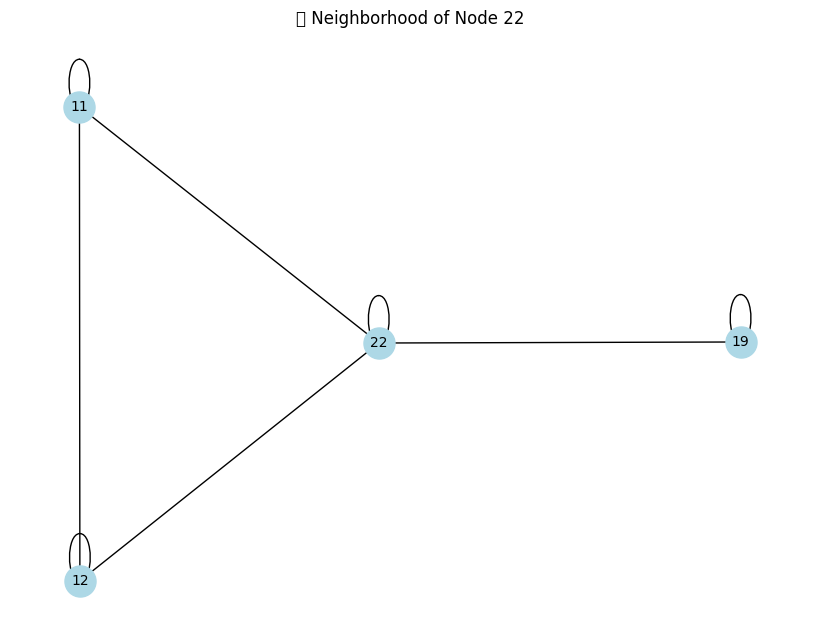

In [87]:
from torch_geometric.utils import k_hop_subgraph
import networkx as nx
import matplotlib.pyplot as plt

# Extract 1-hop subgraph around the critical node
subset, sub_edge_index, _, _ = k_hop_subgraph(node_idx, 1, data.edge_index)

# Convert to NetworkX graph
G = nx.Graph()
G.add_edges_from(sub_edge_index.t().tolist())

# # Highlight the critical node
# node_colors = ['red' if i == node_idx else 'lightblue' for i in subset]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title(f"🔍 Neighborhood of Node {node_idx}")
plt.show()


# Creating LLM Database

In [96]:
# Cell: generate_synthetic_logs_for_llm_fixed.py
import os
import json
import random
import numpy as np
import scipy.io as sio
import pandas as pd
import torch

from torch_geometric.utils import k_hop_subgraph

# ------------ USER CONFIG -------------
DATA_DIR = os.getcwd()
OUT_DIR = os.getcwd()
os.makedirs(OUT_DIR, exist_ok=True)

USE_MODEL_PREDICTIONS = True
TOP_K = 3
TEMPLATES_PER_SAMPLE = 3

CSV_OUT = os.path.join(OUT_DIR, "logs.csv")
JSONL_OUT = os.path.join(OUT_DIR, "llm_dataset.jsonl")
# -------------------------------------


# ------------ Helper: load mats -------------
def load_mat_files(path):
    def load(name):
        p = os.path.join(path, name)
        if not os.path.exists(p):
            raise FileNotFoundError(p)
        return sio.loadmat(p)
    mats = {}
    mats["X_mat"] = load("X.mat")
    mats["Y_polar_mat"] = load("Y_polar.mat")
    mats["edge_index_mat"] = load("edge_index.mat")
    mats["edge_attr_mat"] = load("edge_attr.mat")
    return mats


# ------------ Interpret shapes & extract arrays -------------
def extract_arrays(mats):
    def first_non_dunder(d):
        for k in d.keys():
            if not k.startswith("__"):
                return d[k]
        return None

    X_raw = first_non_dunder(mats["X_mat"])
    Y_raw = first_non_dunder(mats["Y_polar_mat"])
    edge_index = first_non_dunder(mats["edge_index_mat"])
    edge_attr = first_non_dunder(mats["edge_attr_mat"])

    def cell_to_list(cell):
        arr = np.array(cell)
        if arr.dtype == object:
            flat = arr.flatten()
            return [np.array(item, dtype=float) for item in flat]
        else:
            return [np.array(cell, dtype=float)]

    X_list = cell_to_list(X_raw)
    Y_list = cell_to_list(Y_raw)

    edge_index_np = np.array(edge_index)
    if edge_index_np.ndim == 2 and edge_index_np.shape[1] == 2:
        edge_index_np = edge_index_np.T
    if edge_index_np.min() == 1:
        edge_index_np = edge_index_np - 1

    return X_list, Y_list, edge_index_np.astype(int), np.array(edge_attr, dtype=float)


# ------------ Templates -------------
LOG_TEMPLATES = [
    "ALARM: , detected voltage deviation at buses {top_nodes} with anomaly scores {top_scores}. Recommend inspection of lines connected to {top_lines}.",
    "Timestamp {t}: Observed significant deviation in voltage magnitudes at buses {top_nodes} (scores: {top_scores}). This may indicate overload or line fault near {top_lines}.",
    "[{t}] Event report: Top affected buses: {top_nodes}. Anomaly scores: {top_scores}. Suggested actions: inspect equipment on lines {top_lines}; verify transformer taps and relay status.",
    "Event at {t}: Buses {top_nodes} show abnormal voltage behavior (scores {top_scores}). Could be due to overload on nearby lines ({top_lines}). Please check protection logs and physical connections.",
    "Summary - T={t}: High anomalies at buses {top_nodes}. Lines implicated: {top_lines}. Severity: {severity}.",
]
PHRASE_VARIANTS = {
    "recommend": ["Recommend inspection of", "Suggest verifying", "Please check"],
    "could_be": ["Could indicate", "Potential cause", "Likely due to"],
}


# ------------ Main generation function -------------
def generate_logs(
    X_list,
    Y_list,
    edge_index,
    edge_attr,
    use_model=USE_MODEL_PREDICTIONS,
    top_k=TOP_K,
    templates_per_sample=TEMPLATES_PER_SAMPLE,
    model=None,
    device="cpu",
):
    n_samples = min(len(X_list), len(Y_list))
    rows, jsonl_items = [], []

    for s in range(n_samples):
        x = X_list[s]
        y = Y_list[s]
        num_nodes = x.shape[0]

        if use_model and (model is not None):
            model.eval()
            x_t = torch.tensor(x, dtype=torch.float, device=device)
            ei_t = torch.tensor(edge_index, dtype=torch.long, device=device)
            with torch.no_grad():
                pred = model(x_t, ei_t)
            pred_v = pred[:, 0].cpu().numpy() if pred.ndim == 2 else pred.cpu().numpy()
        else:
            pred_v = x[:, 2].astype(float) if x.shape[1] >= 3 else np.zeros(num_nodes)

        if y.ndim == 2 and y.shape[1] >= 1:
            true_v = np.array(y[:, 0], dtype=float)
        else:
            true_v = pred_v.copy()

        residuals = np.abs(pred_v - true_v)
        scores = residuals / (residuals.max() + 1e-12)

        top_idx = np.argsort(-scores)[:top_k]
        top_nodes = [int(i) for i in top_idx]
        top_scores = [float(round(float(scores[i]), 3)) for i in top_idx]

        # implicated lines
        ei = np.array(edge_index, dtype=int)
        edges = ei.T.tolist()
        implicated_lines = set()
        for i in top_nodes:
            for e_idx, (u, v) in enumerate(edges):
                if int(u) == int(i) or int(v) == int(i):
                    implicated_lines.add(e_idx)
        implicated_lines = sorted(list(implicated_lines))[:5]
        implicated_lines_str = (
            ", ".join(str(x) for x in implicated_lines) if implicated_lines else "N/A"
        )

        # ---------------------------
        # NEW: Graph-based influencing node detection
        # ---------------------------
        ei = np.array(edge_index, dtype=int)
        if ei.shape[0] != 2:
            ei = ei.T
        adj = {i: set() for i in range(num_nodes)}
        for u, v in ei.T:
            adj[int(u)].add(int(v))
            adj[int(v)].add(int(u))

        nodes_affecting_node = {}
        for node_index in top_idx:
            one_hop = adj[node_index]
            two_hop = set()
            for n1 in one_hop:
                two_hop.update(adj[n1])
            affecting_nodes = sorted(list(one_hop.union(two_hop)))
            nodes_affecting_node[node_index] = affecting_nodes

        # severity
        avg_top = float(np.mean(top_scores)) if len(top_scores) > 0 else 0.0
        if avg_top > 0.6:
            severity = "HIGH"
        elif avg_top > 0.3:
            severity = "MEDIUM"
        else:
            severity = "LOW"

        for t_i in range(templates_per_sample):
            tpl = random.choice(LOG_TEMPLATES)
            tstamp = f"{s:05d}"
            phr = tpl.format(
                t=tstamp,
                top_nodes=", ".join(str(n) for n in top_nodes),
                top_scores=", ".join(str(sv) for sv in top_scores),
                top_lines=implicated_lines_str,
                severity=severity,
            )

            if severity == "HIGH":
                extra_note = random.choice(PHRASE_VARIANTS["recommend"]) + " critical lines and check relays."
            elif severity == "MEDIUM":
                extra_note = random.choice(PHRASE_VARIANTS["could_be"]) + " temporary overload or switching event."
            else:
                extra_note = "Monitor the area for further signs."

            log_text = phr + " " + extra_note

            explainer_dict_str = (
                json.dumps({str(int(k)): v for k, v in nodes_affecting_node.items()})
                if nodes_affecting_node
                else "{}"
                )
            prompt = (
                f"GNN summary: top_nodes={top_nodes}; scores={top_scores}; implicated_lines={implicated_lines_str}; "
                f"severity={severity}; GNNExplainer_affecting:{explainer_dict_str}\n"
                "System logs: <SYSTEM_LOGS_HERE>\n"
                '''Task (You are an AI Fault Diagnosis Expert):
                You are a domain-specific AI designed to analyze electrical faults in power grids."
                The graph represents an electrical power network where:
                - Nodes correspond to bus systems carrying voltage and load.
                - GNN-derived node scores indicate probability of fault occurrence.
                - Edges represent transmission lines carrying real and reactive power flow.
                - GNNExplainer_affecting lists the most influential nodes/lines contributing to the fault.

                Your objectives:
                1. Identify the MOST LIKELY FAULT LOCATION (node or transmission line).
                2. Determine its IMPACT on voltage stability, line overload, and cascading risk.
                3. Provide SPECIFIC, TECHNICAL corrective actions (e.g., load shedding, capacitor insertion, line isolation).
                4. Use power system engineering terminology. Avoid generic statements. Do NOT repeat the prompt.
                5. Final answer must follow this exact structure:

                Diagnosis:
                - Most probable fault location:
                - Evidence from GNN output:
                - Impact on grid stability:
                - Recommended action plan:
                '''
            ).strip()

            completion = f"""Most probable fault location: Bus {top_nodes[0]}, associated with transmission lines {implicated_lines_str[0]} and {implicated_lines_str[1]}. 
                            The GNN score of {top_scores[0]} indicates a severe anomaly concentrated at this node. Evidence from GNN output: GNNExplainer shows strong influence from upstream buses 
                            {list(explainer_dict_str.keys())[0]}-{list(explainer_dict_str.keys())[1]}, suggesting voltage collapse propagation.\nImpact on grid stability: High risk of 
                            cascading failure and reactive power deficit spreading to buses {top_nodes[1]} and {top_nodes[2]}. Potential overloading of lines {implicated_lines_str} If unmitigated, this could 
                            lead to under-voltage load shedding.\nRecommended actions:\n• Isolate transmission line 17 to prevent fault current backflow.\n• Inject reactive 
                            power compensation at bus 17 using capacitor banks.\n• Activate load shedding protocol for low-priority feeders connected to bus 9.\n• Monitor 
                            frequency deviation and initiate AGC (Automatic Generation Control) if frequency drops below threshold.\n"""

            rows.append(
                {
                    "sample_id": s,
                    "variant": t_i,
                    "log_text": log_text,
                    "top_nodes": top_nodes,
                    "top_scores": top_scores,
                    "implicated_lines": implicated_lines,
                    "severity": severity,
                    "nodes_affecting_node": nodes_affecting_node,
                }
            )
            jsonl_items.append({"prompt": prompt, "completion": completion})

    return rows, jsonl_items


# ------------ Run everything -------------
print("Loading .mat files from", DATA_DIR)
mats = load_mat_files(DATA_DIR)
X_list, Y_list, edge_index, edge_attr = extract_arrays(mats)
print(f"Found {len(X_list)} samples, edge_index shape = {edge_index.shape}.")

model_obj = model_final
device = "cpu"

rows, jsonl_items = generate_logs(
    X_list,
    Y_list,
    edge_index,
    edge_attr,
    use_model=USE_MODEL_PREDICTIONS,
    top_k=TOP_K,
    templates_per_sample=TEMPLATES_PER_SAMPLE,
    model=model_obj,
    device=device,
)

output_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/general-purpose-compute/code/Users/2606536312/Powerflow/llmDataset"
csv_path = os.path.join(output_dir, "CSV_OUT_v1.csv")
jsonl_path = os.path.join(output_dir, "JSONL_OUT_v1.jsonl")

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save CSV
df = pd.DataFrame(rows)
df.to_csv(csv_path, index=False)
print("Saved logs CSV to", csv_path)

# Save JSONL
with open(jsonl_path, "w", encoding="utf-8") as f:
    for item in jsonl_items:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")
print("Saved LLM JSONL to", jsonl_path)

# Print example logs
print("\nExample logs (first 3):")
for r in rows[:3]:
    print("-", r["log_text"])




Loading .mat files from /mnt/batch/tasks/shared/LS_root/mounts/clusters/general-purpose-compute/code/Users/2606536312/Powerflow
Found 34834 samples, edge_index shape = (2, 92).
Saved logs CSV to /mnt/batch/tasks/shared/LS_root/mounts/clusters/general-purpose-compute/code/Users/2606536312/Powerflow/llmDataset/CSV_OUT_v1.csv
Saved LLM JSONL to /mnt/batch/tasks/shared/LS_root/mounts/clusters/general-purpose-compute/code/Users/2606536312/Powerflow/llmDataset/JSONL_OUT_v1.jsonl

Example logs (first 3):
- Timestamp 00000: Observed significant deviation in voltage magnitudes at buses 14, 9, 17 (scores: 1.0, 0.516, 0.48). This may indicate overload or line fault near 17, 20, 26, 33, 34. Suggest verifying critical lines and check relays.
- Summary - T=00000: High anomalies at buses 14, 9, 17. Lines implicated: 17, 20, 26, 33, 34. Severity: HIGH. Please check critical lines and check relays.
- Event at 00000: Buses 14, 9, 17 show abnormal voltage behavior (scores 1.0, 0.516, 0.48). Could be due 

In [95]:
35+65

100